In [1]:
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For parametric fitting
from scipy import optimize

In [43]:
data = pd.read_csv('2021-05-25_trends.csv')
data.head()
# Pre-processing the data
data = data[data['Location']=='US']
data = data[data.notna()]
data.head()

,Date,Location,ShortName,LongName,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Admin_Dose_2_Daily,Admin_Dose_2_Cumulative,Admin_Dose_2_Day_Rolling_Average,Series_Complete_Daily,Series_Complete_Cumulative,Series_Complete_Day_Rolling_Average,date_type,Administered_daily_change_report,Administered_daily_change_report_7dayroll
0,2020-12-13,US,USA,United States,12872.0,12872.0,12872.0,11348.0,11348.0,11348.0,1355.0,1355.0,1355.0,1463.0,1463.0,1463.0,Admin,NaN,NaN
1,2020-12-14,US,USA,United States,3853.0,16725.0,8362.0,3725.0,15073.0,7537.0,5.0,1360.0,680.0,30.0,1493.0,746.0,Admin,NaN,NaN
2,2020-12-15,US,USA,United States,49564.0,66289.0,22096.0,46093.0,61166.0,20389.0,27.0,1387.0,462.0,60.0,1553.0,517.0,Admin,NaN,NaN
3,2020-12-16,US,USA,United States,160221.0,226510.0,56627.0,153277.0,214443.0,53611.0,208.0,1595.0,399.0,244.0,1797.0,449.0,Admin,NaN,NaN
4,2020-12-17,US,USA,United States,273269.0,499779.0,99955.0,262051.0,476494.0,95299.0,515.0,2110.0,422.0,544.0,2341.0,468.0,Admin,NaN,NaN


In [44]:
data = data[['Date', 'Administered_7_Day_Rolling_Average']]
data = data.dropna()
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data

,Administered_7_Day_Rolling_Average
Date,
2020-12-13,12872.0
2020-12-14,8362.0
2020-12-15,22096.0
2020-12-16,56627.0
2020-12-17,99955.0
...,...
2021-05-21,1559074.0
2021-05-22,1471707.0
2021-05-23,1398673.0


<AxesSubplot:xlabel='Date'>

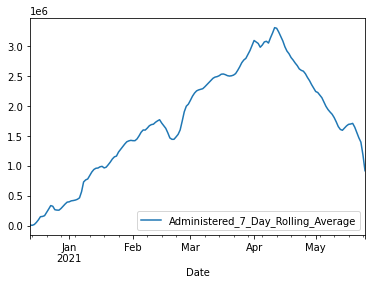

In [50]:
data.plot()

In [51]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y
## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata=np.arange(len(data['Administered_7_Day_Rolling_Average'])), 
                                ydata=data['Administered_7_Day_Rolling_Average'].values)
                                
                                # p0=[1, np.mean(data['Administered_7_Day_Rolling_Average']), 1])
## print the parameters
gaussian_model

array([2.83471850e+06, 1.09464594e+02, 4.62594033e+01])

In [56]:
dtf = data

In [57]:
'''
Plot parametric fitting.
'''
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [91]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve(ts, f, model, pred_ahead=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = pd.date_range(start='2021-05-25',periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

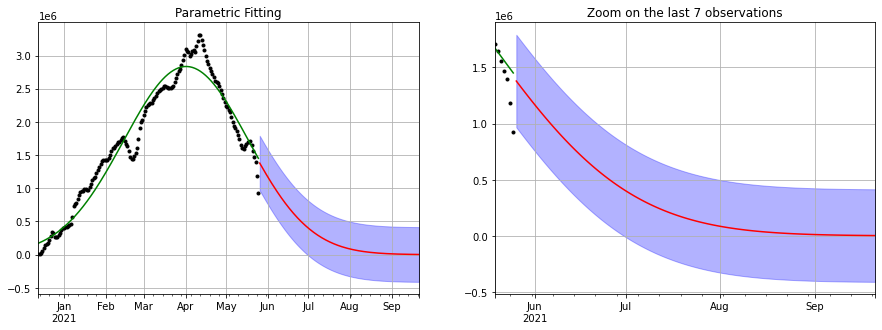

In [92]:
preds = forecast_curve(dtf["Administered_7_Day_Rolling_Average"], gaussian_f, gaussian_model, 
                       pred_ahead=120, freq="D", zoom=7)

In [77]:
c0 = np.load('dates_youyang.npy')
c1 = np.load('daily_vax_dose_1_youyang.npy')
yy_preds = pd.DataFrame([c0,c1]).transpose()
yy_preds.set_index(0)

,1
0,
2020-12-11,0.0
2020-12-12,0.0
2020-12-13,0.0
2020-12-14,33000.0
2020-12-15,67000.0
...,...
2021-12-28,130000.0
2021-12-29,128000.0
2021-12-30,126000.0


<AxesSubplot:>

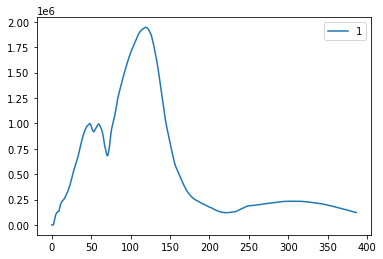

In [78]:
yy_preds.plot()

In [94]:
preds['forecast'].dropna()

2021-05-26    1.378942e+06
2021-05-27    1.343303e+06
2021-05-28    1.307973e+06
2021-05-29    1.272977e+06
2021-05-30    1.238338e+06
                  ...     
2021-09-17    3.434962e+03
2021-09-18    3.172588e+03
2021-09-19    2.928885e+03
2021-09-20    2.702640e+03
2021-09-21    2.492706e+03
Name: forecast, Length: 119, dtype: float64

In [117]:
all_df = pd.concat([preds['model'].dropna(),preds['forecast'].dropna()])
all_df = pd.DataFrame(all_df)
all_df


,0
2020-12-13,172424.690860
2020-12-14,181431.869686
2020-12-15,190820.376485
2020-12-16,200600.944226
2020-12-17,210784.295056
...,...
2021-09-17,3434.961941
2021-09-18,3172.587618
2021-09-19,2928.885356
2021-09-20,2702.639828


In [118]:
all_df.columns = ['Predictions']
all_df

,Predictions
2020-12-13,172424.690860
2020-12-14,181431.869686
2020-12-15,190820.376485
2020-12-16,200600.944226
2020-12-17,210784.295056
...,...
2021-09-17,3434.961941
2021-09-18,3172.587618
2021-09-19,2928.885356
2021-09-20,2702.639828


In [119]:
all_df.index.names = ['Date']
all_df

,Predictions
Date,
2020-12-13,172424.690860
2020-12-14,181431.869686
2020-12-15,190820.376485
2020-12-16,200600.944226
2020-12-17,210784.295056
...,...
2021-09-17,3434.961941
2021-09-18,3172.587618
2021-09-19,2928.885356


In [121]:
all_df.to_csv('vaccine_forecasts.csv')

In [126]:
(pd.read_csv('vaccine_forecasts.csv')['Predictions']<0).any()

False